In [1]:
from data.data_usage import test_kis_live_price, test_kis_live_quote
ws = test_kis_live_price()
#ws = test_kis_live_quote()

주식 체결 시간   |   주식 현재가   |   체결 거래량   |   체결 구분
--------------------------------------------------------------------------------
['005930', '092349', '59800', '2', '700', '1.18', '59543.61', '59600', '59800', '59300', '59800', '59700', '3', '3451016', '205485946700', '2345', '12270', '9925', '165.90', '1122933', '1862986', '1', '0.54', '19.08', '090011', '2', '200', '091859', '3', '0', '090144', '2', '500', '20220811', '20', 'N', '328386', '112553', '1433793', '2631696', '0.06', '4765393', '72.42', '0', '', '59600', '005930', '092349', '59800', '2', '700', '1.18', '59543.61', '59600', '59800', '59300', '59800', '59700', '1', '3451017', '205486006500', '2345', '12271', '9926', '165.90', '1122933', '1862987', '1', '0.54', '19.08', '090011', '2', '200', '091859', '3', '0', '090144', '2', '500', '20220811', '20', 'N', '328386', '112553', '1433793', '2631696', '0.06', '4765393', '72.42', '0', '', '59600']
['005930', '092349', '59800', '2', '700', '1.18', '59543.61', '59600', '59800', '59300'

### 절대 모멘텀

In [ ]:
import os 
import glob
import pandas as pd
import numpy as np
import datetime

from data.lds.lds_handler import LocalDataStorage as lds
from datetime import datetime
import pandas as pd
import numpy as np

startTime_string = '2018-08-10'
endTime_string = '2022-08-10'
datetime_format = '%Y-%m-%d'

code = 'A'+'244580'
#head = '삼성전자'

start_date = datetime.strptime(startTime_string, datetime_format)
end_date = datetime.strptime(endTime_string, datetime_format)

#data = lds.get_chart_min_data('A005930', start_date, end_date)
data = lds.get_strategy_day_data(code , startTime_string, endTime_string)
data


date_list = []
price_list = []
code_list = []
for i in range(0, len(data)):
    date_list.append(data[i]['date'].strftime('%Y-%m-%d'))
    price_list.append(data[i]['close_price'])
    code_list.append(code)
day_data = pd.DataFrame((zip(date_list, price_list, code_list)), columns = ['date', 'close_price', 'code']).copy()

In [23]:
def returns(book, ticker):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == '' :
            # long 진입
            buy = book.loc[i, 'close_price']
            print('진입일 : ',i, 'long 진입가격 : ', buy)

        elif book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == 'buy '+ ticker :
            # 보유중
            current = book.loc[i, 'close_price']
            rtn = (current - buy) / buy + 1
            book.loc[i, 'return'] = rtn

        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:
            # long 청산
            sell = book.loc[i, 'close_price']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ',buy, ' | long 청산가격 : ', sell, ' | return:', round(rtn, 4))

        if book.loc[i, 'trade'] == '': # 제로 포지션
            buy = 0.0
            sell = 0.0
            current = 0.0
            
    acc_rtn = 1.0
    for i in book.index:
        if book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:
            # long 청산 시
            rtn = book.loc[i, 'return']
            acc_rtn = acc_rtn * rtn
            book.loc[i:, 'acc return'] = acc_rtn
    print('Accunulated return :', round(acc_rtn, 4))
    return(round(acc_rtn, 4))


In [4]:
import os 
import glob
import pandas as pd
import numpy as np
import datetime

from data.lds.lds_handler import LocalDataStorage as lds
from datetime import datetime
import pandas as pd
import numpy as np

startTime_string = '2018-08-10'
endTime_string = '2022-08-10'
datetime_format = '%Y-%m-%d'

code = 'A'+'244580'
#head = '삼성전자'

start_date = datetime.strptime(startTime_string, datetime_format)
end_date = datetime.strptime(endTime_string, datetime_format)

#data = lds.get_chart_min_data('A005930', start_date, end_date)
data = lds.get_strategy_day_data(code , startTime_string, endTime_string)
data


date_list = []
price_list = []
code_list = []
for i in range(0, len(data)):
    date_list.append(data[i]['date'].strftime('%Y-%m-%d'))
    price_list.append(data[i]['close_price'])
    code_list.append(code)
day_data = pd.DataFrame((zip(date_list, price_list, code_list)), columns = ['date', code]).copy()

day_data['std_ym'] = day_data['date'].map(lambda x : datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%m'))

month_list = day_data['std_ym'].unique()
month_last_df = pd.DataFrame()

for m in month_list:
    tmp_data = day_data.loc[day_data[day_data['std_ym']== m].index[-1], : ].tolist()
    tmp_data = {'date' : [tmp_data[0]], 'close_price' : [tmp_data[1]], 'std_ym' : [tmp_data[2]]}
    tmp_df = pd.DataFrame(tmp_data)
    month_last_df = pd.concat([month_last_df, tmp_df], axis=0)
    #month_last_df = month_last_df.append(day_data.loc[day_data[day_data['std_ym']== m].index[-1], : ])
month_last_df.set_index(['date'],inplace=True)
month_last_df['BF_1M_Adj Close'] = month_last_df.shift(1)['close_price']
month_last_df['BF_12M_Adj Close'] = month_last_df.shift(12)['close_price']
month_last_df.fillna(0, inplace=True)

book = day_data.copy()
book.set_index(['date'],inplace=True)
book['trade'] = ''

ticker = 'LG화학'
for x in month_last_df.index:
    signal = ''
    momentum_index = month_last_df.loc[x, 'BF_1M_Adj Close'] / month_last_df.loc[x,'BF_12M_Adj Close'] -1
    flag = True if ((momentum_index > 0.0) and (momentum_index != np.inf) and (momentum_index != -np.inf)) \
    else False \
    and True
    if flag:
        signal = 'buy ' + ticker
    print('날짜 : ',x,' 모멘텀 인덱스 : ',momentum_index, 'flag : ',flag ,'signal : ',signal)
    book.loc[x:,'trade'] = signal

returns(book,ticker)

날짜 :  2018-01-31  모멘텀 인덱스 :  nan flag :  False signal :  
날짜 :  2018-02-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-03-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-04-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-05-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-06-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-07-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-08-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-09-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-10-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-11-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2018-12-28  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2019-01-31  모멘텀 인덱스 :  -0.1967592592592593 flag :  False signal :  
날짜 :  2019-02-28  모멘텀 인덱스 :  -0.03916449086161877 flag :  False signal :  
날짜 :  2019-03-29  모멘텀 인덱스 :  0.012970168612191912 flag :  True signal :  buy SPY
날짜 :  2019-04-30  모멘텀 인덱스 :  0.016666666666666607 flag :  True signal :  b

/tmp/ipykernel_271/2234683916.py:48: RuntimeWarning: invalid value encountered in double_scalars
  momentum_index = month_last_df.loc[x, 'BF_1M_Adj Close'] / month_last_df.loc[x,'BF_12M_Adj Close'] -1
/tmp/ipykernel_271/2234683916.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  momentum_index = month_last_df.loc[x, 'BF_1M_Adj Close'] / month_last_df.loc[x,'BF_12M_Adj Close'] -1


NameError: name 'returns' is not defined

### 상대 모멘텀

In [5]:
def data_preprocessing(sample, ticker, base_date):   
    sample['code'] = ticker # 종목코드 추가
    sample = sample[sample['date'] >= base_date][['date','code','close_price']].copy() # 기준일자 이후 데이터 사용
    sample.reset_index(inplace= True, drop= True)
    # 기준년월 
    sample['STD_YM'] = sample['date'].map(lambda x : datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m')) 
    sample['1M_RET'] = 0.0 # 수익률 컬럼
    ym_keys = list(sample['STD_YM'].unique()) # 중복 제거한 기준년월 리스트
    return sample, ym_keys

def create_trade_book(sample, sample_codes):
    book = pd.DataFrame()
    book = sample[sample_codes].copy()
    book['STD_YM'] = book.index.map(lambda x : datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
    for c in sample_codes:
        book['p '+c] = ''
        book['r '+c] = ''
    return book

# 상대모멘텀 tradings
def tradings(book, s_codes):
    std_ym = ''
    buy_phase = False
    # 종목코드별 순회
    for s in s_codes : 
        print(s)
        # 종목코드 인덱스 순회
        for i in book.index:
            # 해당 종목코드 포지션을 잡아준다. 
            if book.loc[i,'p '+s] == '' and book.shift(1).loc[i,'p '+s] == 'ready ' + s:
                std_ym = book.loc[i,'STD_YM']
                buy_phase = True
            # 해당 종목코드에서 신호가 잡혀있으면 매수상태를 유지한다.
            if book.loc[i,'p '+s] == '' and book.loc[i,'STD_YM'] == std_ym and buy_phase == True : 
                book.loc[i,'p '+s] = 'buy ' + s
            
            if book.loc[i,'p '+ s] == '' :
                std_ym = None
                buy_phase = False
    return book

def multi_returns(book, s_codes):
    # 손익 계산
    rtn = 1.0
    buy_dict = {}
    num = len(s_codes)
    sell_dict = {}
    
    for i in book.index:
        for s in s_codes:
            if book.loc[i, 'p ' + s] == 'buy '+ s and \
            book.shift(1).loc[i, 'p '+s] == 'ready '+s and \
            book.shift(2).loc[i, 'p '+s] == '' :     # long 진입
                buy_dict[s] = book.loc[i, s]
#                 print('진입일 : ',i, '종목코드 : ',s ,' long 진입가격 : ', buy_dict[s])
            elif book.loc[i, 'p '+ s] == '' and book.shift(1).loc[i, 'p '+s] == 'buy '+ s:     # long 청산
                sell_dict[s] = book.loc[i, s]
                # 손익 계산
                rtn = (sell_dict[s] / buy_dict[s]) -1
                book.loc[i, 'r '+s] = rtn
                print('개별 청산일 : ',i,' 종목코드 : ', s , 'long 진입가격 : ', buy_dict[s], ' |  long 청산가격 : ',\
                      sell_dict[s],' | return:', round(rtn * 100, 2),'%') # 수익률 계산.
            if book.loc[i, 'p '+ s] == '':     # zero position || long 청산.
                buy_dict[s] = 0.0
                sell_dict[s] = 0.0


    acc_rtn = 1.0        
    for i in book.index:
        rtn  = 0.0
        count = 0
        for s in s_codes:
            if book.loc[i, 'p '+ s] == '' and book.shift(1).loc[i,'p '+ s] == 'buy '+ s: 
                # 청산 수익률계산.
                count += 1
                rtn += book.loc[i, 'r '+s]
        if (rtn != 0.0) & (count != 0) :
            acc_rtn *= (rtn /count )  + 1
            print('누적 청산일 : ',i,'청산 종목수 : ',count, \
                  '청산 수익률 : ',round((rtn /count),4),'누적 수익률 : ' ,round(acc_rtn, 4)) # 수익률 계산.
        book.loc[i,'acc_rtn'] = acc_rtn
    print ('누적 수익률 :', round(acc_rtn, 4))


In [2]:
import os 
import glob
import pandas as pd
import numpy as np
import datetime

from data.lds.lds_handler import LocalDataStorage as lds
from datetime import datetime
import pandas as pd
import numpy as np

startTime_string = '2018-08-10'
endTime_string = '2022-08-10'
datetime_format = '%Y-%m-%d'

code = 'A'+'244580'
#head = '삼성전자'

start_date = datetime.strptime(startTime_string, datetime_format)
end_date = datetime.strptime(endTime_string, datetime_format)

#data = lds.get_chart_min_data('A005930', start_date, end_date)
data = lds.get_strategy_day_data(code , startTime_string, endTime_string)
data


date_list = []
price_list = []
code_list = []
for i in range(0, len(data)):
    date_list.append(data[i]['date'].strftime('%Y-%m-%d'))
    price_list.append(data[i]['close_price'])
    code_list.append(code)
day_data = pd.DataFrame((zip(date_list, price_list, code_list)), columns = ['date', 'close_price', 'code']).copy()
#day_data.to_csv(f'./{code}.csv')

In [5]:
import os 
import glob
import pandas as pd
import numpy as np
import datetime

from data.lds.lds_handler import LocalDataStorage as lds
from datetime import datetime
import pandas as pd
import numpy as np

startTime_string = '2018-08-10'
endTime_string = '2022-08-10'
datetime_format = '%Y-%m-%d'

# code = 'A'+'005930'
# head = '삼성전자'

# start_date = datetime.strptime(startTime_string, datetime_format)
# end_date = datetime.strptime(endTime_string, datetime_format)

# #data = lds.get_chart_min_data('A005930', start_date, end_date)
# data = lds.get_strategy_day_data(code , startTime_string, endTime_string)
# data

# date_list = []
# price_list = []
# code_list = []
# for i in range(0, len(data)):
#     date_list.append(data[i]['date'].strftime('%Y-%m-%d'))
#     price_list.append(data[i]['close_price'])
#     code_list.append(code)
# day_data = pd.DataFrame((zip(date_list, price_list, code_list)), columns = ['date', 'close_price', 'code']).copy()


#종목 데이터 읽어오기.
files = glob.glob('./*.csv')

# 필요한 데이터 프레임 생성
# Monthly 데이터를 저장하기 위함이다.
month_last_df = pd.DataFrame(columns=['date','code','1M_RET'])
# 종목 데이터 프레임 생성
stock_df = pd.DataFrame(columns =['date','code','close_price'])

#read_df = day_data

for file in files:
    """
    데이터 저장 경로에 있는 개별 종목들을 읽어온다.
    """
    if os.path.isdir(file):
        print('%s <DIR> '%file)
    else:
        folder, name = os.path.split(file)
        head, tail = os.path.splitext(name)
        print(file)
        read_df = pd.read_csv(file) # 경로를 읽은 데이터를 하나씩 읽어들인다.
        
    # 1단계. 데이터 가공
    price_df, ym_keys = data_preprocessing(read_df,head,base_date=startTime_string)

    # 가공한 데이터 붙이기.
    tmp_df = price_df.loc[:,['date','code','close_price']]
    stock_df = pd.concat([stock_df, tmp_df],axis=0)
    #stock_df = stock_df.append(price_df.loc[:,['date','code','close_price']],sort=False)

    # 월별 상대모멘텀 계산을 위한 1개월간 수익률 계산
    for ym in ym_keys:
        m_ret = price_df.loc[price_df[price_df['STD_YM'] == ym].index[-1],'close_price'] \
        / price_df.loc[price_df[price_df['STD_YM'] == ym].index[0],'close_price'] 
        price_df.loc[price_df['STD_YM'] == ym, ['1M_RET']] = m_ret

        tmp_data = price_df.loc[price_df[price_df['STD_YM'] == ym].index[-1],\
                                                                ['date','code','1M_RET']].tolist()
        tmp_data = {'date' : [tmp_data[0]], 'code' : [tmp_data[1]], '1M_RET' : [tmp_data[2]]}
        tmp_df = pd.DataFrame(tmp_data)
                                                                                                                                    
        month_last_df = pd.concat([month_last_df, tmp_df],axis=0)


# 2단계. 상대모멘텀 수익률로 filtering 하기.
month_ret_df = month_last_df.pivot('date','code','1M_RET').copy()
month_ret_df = month_ret_df.rank(axis=1, ascending=False, method='max', pct=True) # 투자종목 선택할 rank 
# 상위 40%에 드는 종목들만 Signal list.
month_ret_df = month_ret_df.where( month_ret_df < 0.4 , np.nan)
month_ret_df.fillna(0,inplace=True)
month_ret_df[month_ret_df != 0] = 1
stock_codes = list(stock_df['code'].unique())

# 3단계. signal list로 trading + positioning
sig_dict = dict()
for date in month_ret_df.index:
    ticker_list = list(month_ret_df.loc[date,month_ret_df.loc[date,:] >= 1.0].index)
    sig_dict[date] = ticker_list
stock_c_matrix = stock_df.pivot('date','code','close_price').copy()
book = create_trade_book(stock_c_matrix, list(stock_df['code'].unique()))

for date,values in sig_dict.items():
    for stock in values:
        book.loc[date,'p '+ stock] = 'ready ' + stock
        
# 3-2  tradings
book = tradings(book, stock_codes)

# 4 단게. 수익률 계산하기.
multi_returns(book, stock_codes)

./A091160.csv
./A091180.csv
./A091230.csv
./A139260.csv
./A244580.csv
./A292150.csv
./A305540.csv
./A305720.csv
./A337140.csv
./A364980.csv
A091160
A091180
A091230
A139260
A244580
A292150
A305540
A305720
A337140
A364980
개별 청산일 :  2018-10-01  종목코드 :  A139260 long 진입가격 :  21363  |  long 청산가격 :  20628  | return: -3.44 %
개별 청산일 :  2018-11-01  종목코드 :  A091180 long 진입가격 :  13737  |  long 청산가격 :  11501  | return: -16.28 %
개별 청산일 :  2018-11-01  종목코드 :  A244580 long 진입가격 :  12761  |  long 청산가격 :  9782  | return: -23.34 %
개별 청산일 :  2018-12-03  종목코드 :  A292150 long 진입가격 :  7387  |  long 청산가격 :  7559  | return: 2.33 %
개별 청산일 :  2018-12-03  종목코드 :  A305720 long 진입가격 :  9897  |  long 청산가격 :  8720  | return: -11.89 %
개별 청산일 :  2019-01-02  종목코드 :  A139260 long 진입가격 :  18351  |  long 청산가격 :  17849  | return: -2.74 %
개별 청산일 :  2019-02-01  종목코드 :  A244580 long 진입가격 :  11074  |  long 청산가격 :  10795  | return: -2.52 %
개별 청산일 :  2019-02-01  종목코드 :  A305720 long 진입가격 :  8112  |  long 청산가격 :  8798  | return: 8

### 듀얼 모멘텀

In [21]:
def data_preprocessing(read_df, base_date):   
    read_df = read_df[read_df['date'] >= base_date].copy()
    read_df.reset_index(inplace=True, drop = True)
    read_df['STD_YM'] = read_df['date'].map(lambda x : datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%m'))
    read_df['1M_RET'] = 0.0
    ym_keys = list(read_df['STD_YM'].unique())
    return read_df, ym_keys

def create_trade_book(sample, sample_codes):
    book = pd.DataFrame()
    book = sample[sample_codes].copy()
    book['STD_YM'] = book.index.map(lambda x : datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
    for c in sample_codes:
        book['p '+c] = ''
        book['r '+c] = ''
    return book

# 상대모멘텀 Positioning
def positions(book, s_codes):
    std_ym = ''
    buy_phase = False
    for s in s_codes : 
        print(s)
        for i in book.index:
            if book.loc[i,'p '+s] == '' and book.shift(1).loc[i,'p '+s] == 'ready ' + s:
                std_ym = book.loc[i,'STD_YM']
                buy_phase = True
            
            if book.loc[i,'p '+s] == '' and book.loc[i,'STD_YM'] == std_ym and buy_phase == True : 
                book.loc[i,'p '+s] = 'buy ' + s
            
            if book.loc[i,'p '+ s] == '' :
                std_ym = None
                buy_phase = False
    return book

def multi_returns(book, s_codes):
    # 손익 계산
    rtn = 1.0
    buy_dict = {}
    num = len(s_codes)
    sell_dict = {}
    
    for i in book.index:
        for s in s_codes:
            if book.loc[i, 'p ' + s] == 'buy '+ s and \
            book.shift(1).loc[i, 'p '+s] == 'ready '+s and \
            book.shift(2).loc[i, 'p '+s] == '' :     # long 진입
                buy_dict[s] = book.loc[i, s]
            elif book.loc[i, 'p '+ s] == '' and book.shift(1).loc[i, 'p '+s] == 'buy '+ s:     # long 청산
                sell_dict[s] = book.loc[i, s]
                # 손익 계산
                rtn = (sell_dict[s] / buy_dict[s]) -1
                book.loc[i, 'r '+s] = rtn
                print('개별 청산일 : ',i,' 종목코드 : ', s , 'long 진입가격 : ', buy_dict[s], ' |  long 청산가격 : ', sell_dict[s], ' | return:', round(rtn * 100, 2),'%') # 수익률 계산.

            if book.loc[i, 'p '+ s] == '':     # zero position || long 청산.
                buy_dict[s] = 0.0
                sell_dict[s] = 0.0


    acc_rtn = 1.0        
    for i in book.index:
        rtn  = 0.0
        count = 0
        for s in s_codes:
            if book.loc[i, 'p '+ s] == '' and book.shift(1).loc[i,'p '+ s] == 'buy '+ s:  # 청산. 이떄 수익률이 나오니깐.
                count += 1
                rtn += book.loc[i, 'r '+s]
        if (rtn != 0.0) & (count != 0) :
            # 내가 후보로 삼은 universe에서  1/n 이라고 가정.
            acc_rtn *= (rtn /count )  + 1
            print('누적 청산일 : ',i,'청산 종목수 : ',count, \
                  '청산 수익률 : ',round((rtn /count),4),'누적 수익률 : ' ,round(acc_rtn, 4)) # 수익률 계산.
        book.loc[i,'acc_rtn'] = acc_rtn
    
    print ('누적 수익률 :', round(acc_rtn, 4))

In [20]:
# read_df = pd.read_csv('./new_us_etf_stock.csv')
# read_df.head()
import os 
import glob
import pandas as pd
import numpy as np
import datetime

from data.lds.lds_handler import LocalDataStorage as lds
from datetime import datetime
import pandas as pd
import numpy as np

startTime_string = '2018-08-10'
endTime_string = '2022-08-10'
datetime_format = '%Y-%m-%d'

code = 'A'+'244580'
#head = '삼성전자'

start_date = datetime.strptime(startTime_string, datetime_format)
end_date = datetime.strptime(endTime_string, datetime_format)

#data = lds.get_chart_min_data('A005930', start_date, end_date)
data = lds.get_strategy_day_data(code , startTime_string, endTime_string)
data


date_list = []
price_list = []
code_list = []
for i in range(0, len(data)):
    date_list.append(data[i]['date'].strftime('%Y-%m-%d'))
    price_list.append(data[i]['close_price'])
    code_list.append(code)
read_df = pd.DataFrame((zip(date_list, price_list, code_list)), columns = ['date', 'close_price', 'code']).copy()
#day_data.to_csv(f'./{code}.csv')

In [22]:
import os 
import glob
import pandas as pd
import numpy as np
import datetime

from data.lds.lds_handler import LocalDataStorage as lds
from datetime import datetime
import pandas as pd
import numpy as np

startTime_string = '2018-08-10'
endTime_string = '2022-08-10'
datetime_format = '%Y-%m-%d'

# code = 'A'+'005930'
# head = '삼성전자'

# start_date = datetime.strptime(startTime_string, datetime_format)
# end_date = datetime.strptime(endTime_string, datetime_format)

# #data = lds.get_chart_min_data('A005930', start_date, end_date)
# data = lds.get_strategy_day_data(code , startTime_string, endTime_string)
# data

# date_list = []
# price_list = []
# code_list = []
# for i in range(0, len(data)):
#     date_list.append(data[i]['date'].strftime('%Y-%m-%d'))
#     price_list.append(data[i]['close_price'])
#     code_list.append(code)
# day_data = pd.DataFrame((zip(date_list, price_list, code_list)), columns = ['date', 'close_price', 'code']).copy()


#종목 데이터 읽어오기.
files = glob.glob('./*.csv')

# 필요한 데이터 프레임 생성
# Monthly 데이터를 저장하기 위함이다.
month_last_df = pd.DataFrame(columns=['date','code','1M_RET'])
# 종목 데이터 프레임 생성
stock_df = pd.DataFrame(columns =['date','code','close_price'])

#read_df = day_data

for file in files:
    """
    데이터 저장 경로에 있는 개별 종목들을 읽어온다.
    """
    if os.path.isdir(file):
        print('%s <DIR> '%file)
    else:
        folder, name = os.path.split(file)
        head, tail = os.path.splitext(name)
        print(file)
        read_df = pd.read_csv(file) # 경로를 읽은 데이터를 하나씩 읽어들인다.
        
    # 1단계. 데이터 가공
    price_df, ym_keys = data_preprocessing(read_df,head,base_date=startTime_string)

    # 가공한 데이터 붙이기.
    tmp_df = price_df.loc[:,['date','code','close_price']]
    read_df = pd.concat([stock_df, tmp_df],axis=0)

./A091160.csv


TypeError: data_preprocessing() got multiple values for argument 'base_date'

In [9]:
month_last_df = pd.DataFrame(columns=['date','code','close_price'])
month_last_ret_df = pd.DataFrame(columns=['date','code','1M_RET'])
price_df, ym_keys = data_preprocessing(read_df, base_date='2010-01-02')

s_codes = list(price_df['code'].unique())

for s in s_codes:
    print(s)
    for ym in ym_keys:
        try : 
            # 절대 모멘텀 사용 종가
            month_last_df= month_last_df.append(price_df.loc[price_df[(price_df['STD_YM'] == ym) \
                                                                      & (price_df['code'] == s)].index[-1]\
                                                             ,['date','code','close_price']\
                                                            ]
                                               )
            
            # 상대 모멘텀 사용 수익률
            m_ret = price_df.loc[price_df[(price_df['STD_YM'] == ym) & (price_df['code'] == s)].index[-1] , 'close_price'] \
            / price_df.loc[price_df[(price_df['STD_YM'] == ym) & (price_df['code'] == s)].index[0] , 'close_price']
            price_df.loc[(price_df['STD_YM'] == ym) & (price_df['code'] == s), ['1M_RET']] = m_ret
            
            
            month_last_ret_df= month_last_ret_df.append(price_df.loc[price_df[(price_df['STD_YM'] == ym) \
                                                                      & (price_df['code'] == s)].index[-1]\
                                                             ,['date','code','1M_RET']\
                                                            ]
                                               )
        except IndexError:
            pass


        

A244580


/tmp/ipykernel_570/4237108890.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_last_df= month_last_df.append(price_df.loc[price_df[(price_df['STD_YM'] == ym) \
/tmp/ipykernel_570/4237108890.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_last_ret_df= month_last_ret_df.append(price_df.loc[price_df[(price_df['STD_YM'] == ym) \
/tmp/ipykernel_570/4237108890.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_last_df= month_last_df.append(price_df.loc[price_df[(price_df['STD_YM'] == ym) \
/tmp/ipykernel_570/4237108890.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  month_last_ret_df= month_last_ret_df.append

In [10]:
month_last_df

,date,code,close_price
14,2018-08-31,A244580,12617
31,2018-09-28,A244580,13230
52,2018-10-31,A244580,9682
74,2018-11-30,A244580,10845
93,2018-12-28,A244580,10650
115,2019-01-31,A244580,10870
132,2019-02-28,A244580,11524
152,2019-03-29,A244580,10995
174,2019-04-30,A244580,10875
195,2019-05-31,A244580,9530


In [11]:
# 12개월 절대 모멘텀 
bf_month = 12
month_last_df.reset_index(inplace=True,drop=True)
month_last_tmp_df = month_last_df.pivot('date','code','close_price').copy()
abs_momentum_filter =  month_last_tmp_df / month_last_tmp_df.shift(bf_month) -1
abs_momentum_filter = abs_momentum_filter.where(abs_momentum_filter > 0.0 , np.nan)
abs_momentum_filter.fillna(0,inplace=True)
abs_momentum_filter[abs_momentum_filter != 0] = 1


# 유니버스 내 상위 20% 상대 모멘텀
ratio = 0.2   # 상위 20%에 드는 종목들만.
month_last_ret_df.reset_index(inplace=True,drop=True)
month_last_ret_df = month_last_ret_df.pivot('date','code','1M_RET').copy()
rel_momentum_filter = month_last_ret_df.rank(axis=1, ascending=False, method="max", pct=True) # 투자종목 선택할 rank
rel_momentum_filter = rel_momentum_filter.where( rel_momentum_filter < ratio , np.nan)
rel_momentum_filter.fillna(0,inplace=True)
rel_momentum_filter[rel_momentum_filter != 0] = 1

#듀얼 모멘텀.
dual_mementum_filter = abs_momentum_filter * rel_momentum_filter # 절대 모멘텀 * 상대 모멘텀 => 듀얼 모멘텀

In [13]:
# 사실상 trading 부분.
sig_dict = dict()
for date in dual_mementum_filter.index:
    ticker_list = list(dual_mementum_filter.loc[date,dual_mementum_filter.loc[date,:] >= 1.0].index)
    sig_dict[date] = ticker_list
    
stock_c_matrix = price_df.pivot('date','code','close_price').copy()
book = create_trade_book(stock_c_matrix, s_codes)
book['STD_YM'] = book.index.map(lambda x : datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))

#ready 표시
for date,values in sig_dict.items():
    for stock in values:
        book.loc[date,'p '+ stock] = 'ready ' + stock
        

# # trading 부분을 만들려고 하는데
book = positions(book, s_codes)

A244580


In [14]:
multi_returns(book, s_codes)

누적 수익률 : 1.0


In [15]:
book.loc['2011-01-30':'2011-02-01',:]  # 진입 포지션 확인

code,A244580,STD_YM,p A244580,r A244580,acc_rtn
date,,,,,


In [16]:
book.loc['2011-02-26':'2011-03-01',:]  # 청산 포지션 확인

code,A244580,STD_YM,p A244580,r A244580,acc_rtn
date,,,,,


### 모멘텀 전략 구현

./A091160.csv
./A091180.csv
./A091230.csv
./A139260.csv
./A244580.csv
./A292150.csv
./A305540.csv
./A305720.csv
./A337140.csv
./A364980.csv


DataError: No numeric types to aggregate

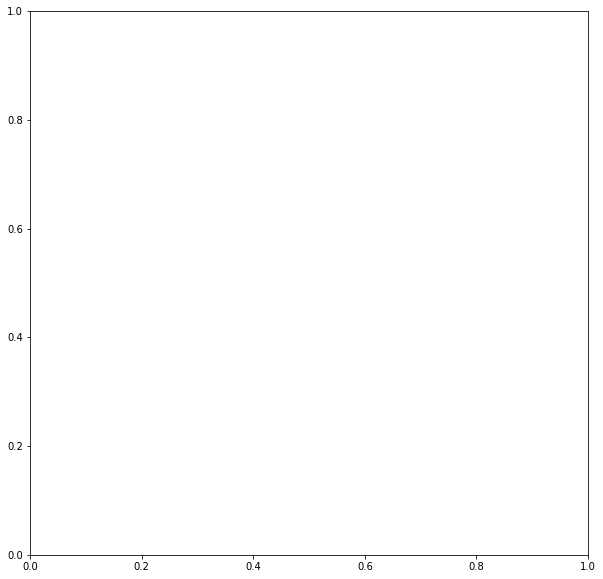

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
from time import time
from scipy.stats import linregress



files = glob.glob('./*.csv')

# 필요한 데이터 프레임 생성
# Monthly 데이터를 저장하기 위함이다.
month_last_df = pd.DataFrame(columns=['date','code','1M_RET'])
# 종목 데이터 프레임 생성
stock_df = pd.DataFrame(columns =['date','code','close_price'])

#read_df = day_data

for file in files:
    """
    데이터 저장 경로에 있는 개별 종목들을 읽어온다.
    """
    if os.path.isdir(file):
        print('%s <DIR> '%file)
    else:
        folder, name = os.path.split(file)
        head, tail = os.path.splitext(name)
        print(file)
        read_df = pd.read_csv(file) # 경로를 읽은 데이터를 하나씩 읽어들인다.
        
    # 1단계. 데이터 가공
    price_df, ym_keys = data_preprocessing(read_df,head,base_date=startTime_string)

    # 가공한 데이터 붙이기.
    tmp_df = price_df.loc[:,['date','code','close_price']]
    stock_df = pd.concat([stock_df, tmp_df],axis=0)
    #stock_df = stock_df.append(price_df.loc[:,['date','code','close_price']],sort=False)





fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

stocks = stock_df
codes = stocks.columns

start = time()

def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252 ) * (rvalue ** 2)    # annualize slope and multiply by R^2

momentums = stocks.copy(deep=True)

for code in codes:
    momentums[code] = stocks[code].rolling(90).apply(momentum)  #각 종목마다 모멘텀 구하는 함수적용

bests = momentums.max().sort_values(ascending=False).index[:5]  # 모멘텀 값이 가장큰 상위 5개 종목을 bests에 넣음  

for best in bests:
    end = momentums[best].index.get_loc(momentums[best].idxmax())   # 모멘텀이 가장 높은 시점 

    if end - 90 < 0 :   #모멘텀이 최고인 시점의 90일 이전이 최초 설정한 2017-01-01보다 이전이면 그냥 생략해버림 
        continue

    rets = np.log(stocks[best])
    momentum_point = stocks[best].index[end].strftime("%Y/%m/%d")   # 모멘텀이 최고인 시점을 label에 표현하기 위함       
    x = np.arange((rets))
    slope, intercept, r_value, p_value, std_err = linregress(x, rets) # 회귀함수 

    try:
        plt.plot(np.arange(180), stocks[best][end-90:end+90], label=[best,momentum_point])  # 모멘텀이 최고인 시점의 90일 전후 종가          
        plt.plot(x, np.e ** (intercept + slope*x))  # 회귀 함수의 결과를 그림 
    except:
        continue

ax.legend(loc=5)
plt.show()
end = time()
print(end-start)

In [9]:
data

[{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f90c052d1c0>,
  'open_price': 179500,
  'date': datetime.date(2015, 1, 2),
  'high_price': 180500,
  'close_price': 180000,
  'code': '051910',
  'low_price': 177000,
  'volume': 231092},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f90857eb340>,
  'open_price': 179000,
  'date': datetime.date(2015, 1, 5),
  'high_price': 179500,
  'close_price': 174500,
  'code': '051910',
  'low_price': 173500,
  'volume': 318170},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f90857eb940>,
  'open_price': 170500,
  'date': datetime.date(2015, 1, 6),
  'high_price': 171000,
  'close_price': 166000,
  'code': '051910',
  'low_price': 163500,
  'volume': 567304},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f90857eb8e0>,
  'open_price': 164000,
  'date': datetime.date(2015, 1, 7),
  'high_price': 167500,
  'close_price': 164500,
  'code': '051910',
  'low_price': 163000,
  'vo